# 1. 必要なライブラリをインポート

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import tensorflow as tf

# 2. データの読み込み（Excelファイル）

In [2]:
from google.colab import drive
drive.mount('/content/drive')

file_path = "/content/drive/My Drive/github/利益予測データベース.xlsx"
df = pd.read_excel(file_path)
df.head(5)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,sample,group,ni_t,ni_t1,ni_t2,ni_t3,ni_t4,ni_t5,cy_e_t1,cy_sale_t1,...,cy_iva_c_t1,cy_intan_c_t1,cy_ap_c_t1,cy_dlc_c_t1,cy_txp_c_t1,cy_dltt_c_t1,cy_re_c_t1,cy_cfo_c_t1,ni_t_mgt,afe_t_mgt
0,201003N0000001,1,0.053142,0.077657,0.073253,0.097867,0.098210,0.067920,0.077657,7.220336,...,-0.025984,0.009102,0.008368,0.135497,-0.011255,0.035526,0.051674,-0.339696,0.088080,0.034939
1,200903N0000001,1,0.083942,0.079182,0.105787,0.106157,0.073416,0.066011,0.079182,7.815907,...,-0.073469,0.002539,-0.052206,-0.333652,0.020470,-0.017614,0.044907,0.587329,0.079340,0.004602
2,200803N0000001,1,0.052085,0.069586,0.069830,0.048293,0.043422,0.039038,0.069586,5.465569,...,-0.083399,0.000139,-0.056052,0.133675,0.000974,-0.031488,0.049406,-0.105840,0.066107,0.014022
3,200703N0000001,1,0.060600,0.060812,0.042056,0.037814,0.033996,0.031088,0.060812,4.632824,...,0.105868,0.005575,0.039057,0.072174,-0.004606,-0.052934,0.043632,0.004212,0.075750,0.015150
4,200603N0000001,1,0.080197,0.055463,0.049869,0.044834,0.040998,0.037042,0.055463,6.099235,...,-0.012547,0.000679,0.018461,-0.114562,0.001758,0.075842,0.035723,-0.049469,0.083914,0.003716


# 3. データ分割

In [3]:
# 'df' (DataFrame) をNumPy配列に変換します
data = df.values

In [4]:
# CYのみ
x_train = data[:, 8:66][data[:, 1] == 1]
y_train = data[:, 2][data[:, 1] == 1]
x_test = data[:, 8:66][data[:, 1] == 2]
y_test = data[:, 2][data[:, 1] == 2]
# - 列0: sample ID（分析に不要）
# - 列1: group（分割ぶんかつ用、特徴量ではない）
# group=1: モデル学習用データ（訓練データ）group=2: モデル評価用データ（テストデータ）
# - 列2: ni_t（予測対象、yとして使用）
# - 列3-7: ni_t1~ni_t5（過去の純利益、今回は使わない）
# - 列8-65: CY財務指標（Current Year、今期のデータ）← これを使用！
# - 列66-67: 経営者予測（今回は使わない）

# データの形状を確認
print(f"訓練データの特徴量: {x_train.shape}")
print(f"訓練データのラベル: {y_train.shape}")
print(f"テストデータの特徴量: {x_test.shape}")
print(f"テストデータのラベル: {y_test.shape}")

訓練データの特徴量: (27011, 58)
訓練データのラベル: (27011,)
テストデータの特徴量: (24008, 58)
テストデータのラベル: (24008,)


In [5]:
# Easton+CY
"""
x_train = data[:, 3:66][data[:, 1] == 1]
y_train = data[:, 2][data[:, 1] == 1]
x_test = data[:, 3:66][data[:, 1] == 2]
y_test = data[:, 2][data[:, 1] == 2]
"""

'\nx_train = data[:, 3:66][data[:, 1] == 1]\ny_train = data[:, 2][data[:, 1] == 1]\nx_test = data[:, 3:66][data[:, 1] == 2]\ny_test = data[:, 2][data[:, 1] == 2]\n'

In [6]:
# Easton 4dimのみ
"""
x_train = data[:, 3:7][data[:, 1] == 1]
y_train = data[:, 2][data[:, 1] == 1]
x_test = data[:, 3:7][data[:, 1] == 2]
y_test = data[:, 2][data[:, 1] == 2]
"""

'\nx_train = data[:, 3:7][data[:, 1] == 1]\ny_train = data[:, 2][data[:, 1] == 1]\nx_test = data[:, 3:7][data[:, 1] == 2]\ny_test = data[:, 2][data[:, 1] == 2]\n'

In [7]:
# ============================================
# 三つの方案の比較と選択理由
# ============================================

# 方案1: CYのみ（58特徴量）
# 利点：
# - 現在の財務状況を詳細に反映
# - 多角的な分析が可能
# 欠点：
# - 過去のトレンドを無視
# - 特徴量が多く、過学習のリスク

# 方案2: Easton+CY（63特徴量）
# 利点：
# - 過去のトレンド＋現在の状況を両方考慮
# - 最も情報量が多い
# 欠点：
# - 特徴量が最も多い（63個）
# - 計算コストが高い

# 方案3: Easton 4dimのみ（4特徴量）
# 利点：
# - シンプルで解釈しやすい
# - 過学習のリスクが低い
# 欠点：
# - 情報量が少ない
# - 現在の財務状況を無視

# 推奨：まずCYのみで試し、次にEaston+CYを試す

# 4.型変換


In [8]:
# 1. 元データは文字列や整数が混在している可能性
# 2. ニューラルネットワークは浮動小数点数floatで計算
x_train = np.array(x_train, dtype=float)
y_train = np.array(y_train, dtype=float)
x_test = np.array(x_test, dtype=float)
y_test = np.array(y_test, dtype=float)

# 5.self_attention定義
*  この関数は、入力された系列データに対してマルチヘッド・セルフアテンション（multi-head
self-attention）を適用し、各特徴量が系列全体の他の特徴量との関係性を自動的に学習できるようにします。
*  最後に残差接続（residual connection）で元の情報も保持しつつ、出力として融合します。Transformer構造の主要なモジュールです。

In [9]:
def self_attention(x, num_heads,key_dim):
  atteion_output = layers.MultiHeadAttention(num_heads=num_heads,key_dim=key_dim)(x,x)
  # → atteion_output.shape: (batch_size, seq_len, num_heads × value_dim)
  # value_dim 設定してない時に＝key_dim
  x = layers.Add()([x,atteion_output])
  return x


# 5.self_attention 解釈

In [10]:
"""
        x
        ↓
  ┌────────────┐
  │  Dense(Wq) │ → Q (query)
  │  Dense(Wk) │ → K (key)
  │  Dense(Wv) │ → V (value)
  └────────────┘
        ↓
Attention(Q, K, V) = softmax(Q·Kᵀ / √dₖ) × V
        ↓
      输出ベクトル

"""

'\n        x\n        ↓\n  ┌────────────┐\n  │  Dense(Wq) │ → Q (query)\n  │  Dense(Wk) │ → K (key)\n  │  Dense(Wv) │ → V (value)\n  └────────────┘\n        ↓\nAttention(Q, K, V) = softmax(Q·Kᵀ / √dₖ) × V\n        ↓\n      输出ベクトル\n\n'

In [12]:
# def self_attention(x, num_heads, key_dim):
"""
    x : tensor 入力テンソル
        形状: (batch_size, sequence_length, projection_dim)
        - batch_size: バッチ内の企業数（例：200社）
        - sequence_length: 特徴量の数（58個の財務指標)
        - projection_dim: 各特徴量のベクトル次元
              投影次元（各特徴量を表現するベクトルの次元数）
              元データ: 各指標は1つの数値
              投影後: 各指標はprojection_dim個の数値で表現
              より豊かな表現力を獲得
              projection_dim = 64 というのは、
              もともと1つのスカラー値だった各特徴量を、64次元のベクトルに変換するという意味です。

    num_heads : int マルチヘッド注意機構のヘッド数- 各ヘッドが異なる観点で関係性を捉える

    key_dim = projection_dim/num_heads

  """


  # attention_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(x, x) # (query, key-value)
"""
  複数のヘッドで並列に注意を計算し、異なる関係性を捉える
  両方xを入力 = 自己注意（self-attention）queryとkey-valueが同じ = 自分自身との関係を見る

    注意機構の内部処理:
    1. Query（質問）: 各指標が「何を知りたいか」
    2. Key（鍵）: 各指標が「何の情報を持っているか」
    3. Value（値）: 実際の情報内容

    計算手順:
    1. 注意スコア = Query × Key^T / √(key_dim)
    2. 注意重み = Softmax(注意スコア)
    3. 出力 = 注意重み × Value

    例: 純利益が他の指標に注意を向ける場合
    - 売上高への注意: 0.8（強い正の関係）
    - 売上原価への注意: 0.7（強い負の関係）
    - 広告費への注意: 0.1（弱い関係）
"""

  # x = layers.Add()([x, attention_output])
  # return x
"""
  残差接続（Residual Connection）元の入力xと注意機構の出力を加算
  残差接続の利点:
      1. 情報の保持: 元の特徴情報を失わない
      2. 勾配の安定: 深いネットワークでも勾配消失を防ぐ
      3. 学習の効率: 「変更」ではなく
      4. スキップ接続: 必要に応
"""

'\n  残差接続（Residual Connection）元の入力xと注意機構の出力を加算\n  残差接続の利点:\n      1. 情報の保持: 元の特徴情報を失わない\n      2. 勾配の安定: 深いネットワークでも勾配消失を防ぐ\n      3. 学習の効率: 「変更」ではなく\n      4. スキップ接続: 必要に応\n'

# 6.VITーTransformer関数

In [13]:
"""
この関数は、財務指標などの系列データ（時系列や表形式の特徴量）をTransformer構造で処理するための前処理モジュールです。
入力データを系列化し、高次元特徴ベクトルに変換しつつ、位置エンコーディング（順序情報）も付加します。
その後、複数層のself-attentionを通じて、特徴量同士の複雑な関係性を学習・融合し、最終的に全ての情報を1次元ベクトルとして出力します。
予測や分類などの下流タスクの入力としてそのまま利用できます。
"""

'\nこの関数は、財務指標などの系列データ（時系列や表形式の特徴量）をTransformer構造で処理するための前処理モジュールです。\n入力データを系列化し、高次元特徴ベクトルに変換しつつ、位置エンコーディング（順序情報）も付加します。\nその後、複数層のself-attentionを通じて、特徴量同士の複雑な関係性を学習・融合し、最終的に全ての情報を1次元ベクトルとして出力します。\n予測や分類などの下流タスクの入力としてそのまま利用できます。\n'

In [20]:
def create_vit(x,sequence_length):

  # 元のx.shape(batch_size, sequence_length)reshapeして次元追加 → (batch_size, sequence_length, 1)
  x = layers.Reshape((sequence_length, 1))(x)

  # projection_dim次元にマッピング（入力が1次元なので、Denseで広げる）
  x = layers.Dense(projection_dim)(x) # shape: (batch_size, sequence_length, projection_dim)

  # 位置エンコーディングの追加
  positions = tf.range(start=0, limit=sequence_length)
  # 0からsequence_length-1 までの位置番号を作成 positions.shape = (sequence_length,)

  position_embedding = layers.Embedding(input_dim=sequence_length, output_dim=projection_dim)(positions)
  # 位置エンコーディングの次元数は projection_dim（特徴ベクトルの次元数）と同じにする必要がある position_embedding.shape= (sequence_length, projection_dim)

  position_embedding = tf.expand_dims(position_embedding, axis=0)
  # 先頭に新しい次元（バッチ次元）を追加する操作です shape: (1, sequence_length, projection_dim)

  x = layers.Add()([x, position_embedding])  # shape matches: (batch_size, sequence_length, projection_dim)

  for _ in range(transformer_layers):
    x = self_attention(x, num_heads, projection_dim)

  x = layers.Flatten()(x)
  # 3次元テンソル（batch_size, sequence_length, projection_dim）を1次元（batch_size, sequence_length * projection_dim）に変換
  return x

# 7.繰り返し予測

In [30]:
%%time
from tensorflow.keras.optimizers import AdamW
# ハイパーパラメータ
num_heads = 3
projection_dim = x_train.shape[1]
key_dim = projection_dim // num_heads
transformer_layers = 1
MAX_TRIALS = 3
epochs = 8
batch_size = 200

# 繰り返し予測
predictions = []
se = []
mean_score = []
score = []

for trial in range(MAX_TRIALS):
  print(f"Trial {trial + 1}/{MAX_TRIALS}")
  sequence_length = x_train.shape[1]
  inputs = layers.Input(shape=(sequence_length,)) # shape: (batch, seq_len)

  x = create_vit(inputs,sequence_length)

  # 全結合層
  #x = layers.Dense(64, activation='relu')(inputs)
  x = layers.Dense(64, activation='relu')(x)
  x = layers.Dense(64, activation='relu')(x)
  #x = layers.Dense(40, activation='relu')(x)

  outputs = layers.Dense(1, activation='linear')(x)

  model = models.Model(inputs=inputs, outputs=outputs)

  model.compile(
  optimizer='adam',      # Adam最適化アルゴリズム
  loss='mae',         # 平均絶対誤差を損失関数に Mean Absolute Error
  metrics=['mae']       # 評価指標もMA
  )

  history = model.fit(x_train, y_train,epochs=epochs, batch_size=batch_size,
  validation_data=(x_test, y_test), verbose=1)

  y_pred = model.predict(x_test, verbose=0).flatten()
  predictions.append(y_pred)
  preds_array = np.array(predictions)

  N = len(predictions)
  se.append(preds_array.std(axis=0) / np.sqrt(N))

  score.append(model.evaluate(x_test, y_test, verbose=0)[0])
  mean_score.append(np.mean(score))

Trial 1/3
Epoch 1/8
136/136 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - loss: 0.0901 - mae: 0.0901 - val_loss: 0.0584 - val_mae: 0.0584
Epoch 2/8
136/136 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0710 - mae: 0.0710 - val_loss: 0.0521 - val_mae: 0.0521
Epoch 3/8
136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0673 - mae: 0.0673 - val_loss: 0.0509 - val_mae: 0.0509
Epoch 4/8
136/136 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0657 - mae: 0.0657 - val_loss: 0.0497 - val_mae: 0.0497
Epoch 5/8
136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0679 - mae: 0.0679 - val_loss: 0.0733 - val_mae: 0.0733
Epoch 6/8
136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0686 - mae: 0.0686 - val_loss: 0.0495 - val_mae: 0.0495
Epoch 7/8
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0650 - mae: 0.0650 - val_loss: 0.0494 - val_mae: 0.0494
Epoch 8/8
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0690 - mae: 0.0690 - val_loss: 0.0545 - val_mae: 0.0545
Trial 2/3
Epoch 1/8
136/136 ━━━━━━━━━━━━━━━━━━━

# ８.可視化

各観測値の95％信頼区間の最大: 0.34458152125317937
各観測値の95％信頼区間の平均: 0.01037094202334096
MAEの平均値: 0.05127025519808134


/tmp/ipython-input-31-821665186.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()#loc='lower right')


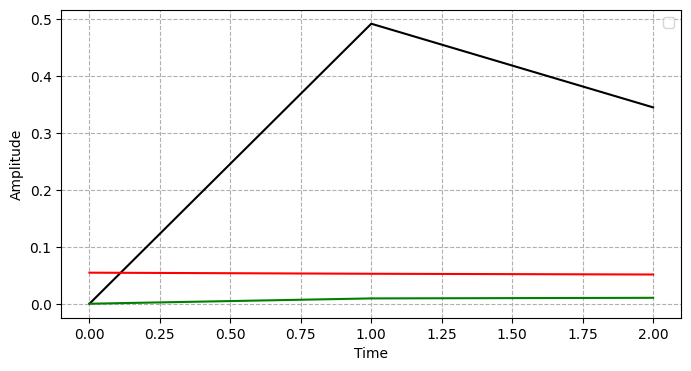

In [31]:
se = np.array(se)
mean_score = np.array(mean_score)

import matplotlib.pyplot as plt

#print(se.shape)
print('各観測値の95％信頼区間の最大:',1.96 * np.max(se, axis = 1)[MAX_TRIALS-1])
print('各観測値の95％信頼区間の平均:',1.96 * np.mean(se, axis = 1)[MAX_TRIALS-1])
#print(mean_score.shape)
print('MAEの平均値:',mean_score[MAX_TRIALS-1])

# Running Test Predictions
plt.figure(figsize=(8, 4))
plt.plot(1.96 *np.max(se,axis = 1), color = "black")
plt.plot(1.96 *np.mean(se,axis = 1), color = "green")
plt.plot(mean_score, color = "red")
plt.legend()#loc='lower right')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.grid(which='major', linestyle='--', axis='both')

plt.show()

# 📘 モデル構造の流れ（形状付き）


In [33]:
"""
入力：企業ごとの財務データ（58個の特徴量）
x.shape = (batch_size, 58)

↓ create_vit関数に入る
1. Reshapeで次元追加（系列化）
   x → (batch_size, 58, 1)

2. Denseで各特徴をベクトル化（特徴投影）
   x → (batch_size, 58, projection_dim=58)

3. 位置エンコーディングを加える（Positional Embedding）
   position_embedding → (1, 58, 58)
   加算後：x + position_embedding → (batch_size, 58, 58)

4. Self-Attention（Multi-Head Attentionで特徴間の依存関係を学習）
   attention_output → (batch_size, 58, 58)
   残差接続後 → (batch_size, 58, 58)

5. Flattenでベクトル化（Transformerの出力を全結合層に渡すため）
   x → (batch_size, 58 × 58) = (batch_size, 3364)

↓ 全結合層（MLP部分）
6. Dense(64) + ReLU
   → (batch_size, 64)

7. Dense(64) + ReLU
   → (batch_size, 64)

8. Dense(1)（線形出力）
   → (batch_size, 1)

出力：予測される純利益
"""

'\n入力：企業ごとの財務データ（58個の特徴量）\nx.shape = (batch_size, 58)\n\n↓ create_vit関数に入る\n1. Reshapeで次元追加（系列化）\n   x → (batch_size, 58, 1)\n\n2. Denseで各特徴をベクトル化（特徴投影）\n   x → (batch_size, 58, projection_dim=58)\n\n3. 位置エンコーディングを加える（Positional Embedding）\n   position_embedding → (1, 58, 58)\n   加算後：x + position_embedding → (batch_size, 58, 58)\n\n4. Self-Attention（Multi-Head Attentionで特徴間の依存関係を学習）\n   attention_output → (batch_size, 58, 58)\n   残差接続後 → (batch_size, 58, 58)\n\n5. Flattenでベクトル化（Transformerの出力を全結合層に渡すため）\n   x → (batch_size, 58 × 58) = (batch_size, 3364)\n\n↓ 全結合層（MLP部分）\n6. Dense(64) + ReLU\n   → (batch_size, 64)\n\n7. Dense(64) + ReLU\n   → (batch_size, 64)\n\n8. Dense(1)（線形出力）\n   → (batch_size, 1)\n\n出力：予測される純利益\n'

In [32]:
"""
学習時のデータフロー（例：x_train.shape = (27011, 58)）

1. Input層 → (27011, 58)

↓ create_vit関数へ（Transformerブロックを含む）

2. Reshape → (27011, 58, 1)

3. Dense（特徴投影）→ (27011, 58, 58)

4. 位置エンコーディングを加算 → (27011, 58, 58)

5. Self-Attention → (27011, 58, 58)

6. Flatten → (27011, 3364)

↓ MLP
7. Dense(64) + ReLU → (27011, 64)

8. Dense(64) + ReLU → (27011, 64)

9. Dense(1) → (27011, 1)

↓ 出力（純利益の予測）
→ y_train（形状：(27011, 1)）と比較して損失を計算（MAE）

逆伝播を通じて全ての重みを更新（Transformerを含む）
"""

'\n学習時のデータフロー（例：x_train.shape = (27011, 58)）\n\n1. Input層 → (27011, 58)\n\n↓ create_vit関数へ（Transformerブロックを含む）\n\n2. Reshape → (27011, 58, 1)\n\n3. Dense（特徴投影）→ (27011, 58, 58)\n\n4. 位置エンコーディングを加算 → (27011, 58, 58)\n\n5. Self-Attention → (27011, 58, 58)\n\n6. Flatten → (27011, 3364)\n\n↓ MLP\n7. Dense(64) + ReLU → (27011, 64)\n\n8. Dense(64) + ReLU → (27011, 64)\n\n9. Dense(1) → (27011, 1)\n\n↓ 出力（純利益の予測）\n→ y_train（形状：(27011, 1)）と比較して損失を計算（MAE）\n\n逆伝播を通じて全ての重みを更新（Transformerを含む）\n'